In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

warnings.filterwarnings("ignore")

pd.set_option("mode.copy_on_write", True)

In [2]:
insurance = pd.read_csv("../01_Data/02_Processed/01_Insurance_NoMissing.csv")
insurance.sample(5)

,YEAR,SEX,RACENEW,INCFAM97ON2,HINOTCOVE,CNLUNG,SMK,Occupation_Code
20358,2001,1,100.0,96.0,2.0,1.0,2,6
36594,2002,1,100.0,30.0,1.0,1.0,1,27
19047,2001,1,100.0,20.0,1.0,1.0,1,22
344274,2015,2,100.0,10.0,1.0,1.0,2,11
153346,2008,2,100.0,10.0,1.0,1.0,2,15


In [3]:
# dropping all values where year is < 2010
insurance = insurance[insurance["YEAR"] >= 2010]

In [4]:
insurance[["HINOTCOVE", "CNLUNG"]].value_counts().reset_index()

,HINOTCOVE,CNLUNG,count
0,1.0,1.0,185178
1,2.0,1.0,32064
2,1.0,2.0,714
3,2.0,2.0,24


In [5]:
insurance.shape

(217980, 8)

> Drop the year variable 

In [6]:
# Drop the 'YEAR' variable
insurance = insurance.drop(columns=["YEAR"])

In [7]:
insurance.head()

,SEX,RACENEW,INCFAM97ON2,HINOTCOVE,CNLUNG,SMK,Occupation_Code
191658,2,100.0,32.0,1.0,1.0,1,1
191659,1,100.0,20.0,2.0,1.0,2,10
191660,1,100.0,20.0,1.0,1.0,1,9
191661,2,100.0,10.0,1.0,1.0,2,10
191662,1,100.0,32.0,1.0,1.0,1,1


## Matching

In [8]:
# Convert all columns to integer type
insurance = insurance.astype(int)

In [9]:
# Display the data types of each column in the DataFrame
print("Data types of each variable in the DataFrame:")
print(insurance.dtypes)

Data types of each variable in the DataFrame:
SEX                int64
RACENEW            int64
INCFAM97ON2        int64
HINOTCOVE          int64
CNLUNG             int64
SMK                int64
Occupation_Code    int64
dtype: object


In [10]:
# Map 1 to 1 and 2 to 0 in the "HINOTCOVE" column
insurance["HINOTCOVE"] = insurance["HINOTCOVE"].map({1: 1, 2: 0})

# Check unique values in the "HINOTCOVE" column after mapping
unique_values = insurance["HINOTCOVE"].unique()
print(unique_values)

[1 0]


In [11]:
# Map 1 to 0 and 2 to 1 in the "CNLUNG" column
insurance["CNLUNG"] = insurance["CNLUNG"].map({1: 0, 2: 1})

# Check unique values in the "CNLUNG" column after mapping
unique_values = insurance["CNLUNG"].unique()
print(unique_values)

[0 1]


In [12]:
import dame_flame

model = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
)
model.fit(
    insurance,
    treatment_column_name="HINOTCOVE",
    outcome_column_name="CNLUNG",
)
result = model.predict(insurance)

Completed iteration 0 of matching
	Number of matched groups formed in total:  991
	Unmatched treated units:  3378 out of a total of  185892 treated units
	Unmatched control units:  33 out of a total of  32088 control units
	Number of matches made this iteration:  214569
	Number of matches made so far:  214569
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.004559796810897787
Completed iteration 1 of matching
	Number of matched groups formed in total:  1000
	Unmatched treated units:  3359 out of a total of  185892 treated units
	Unmatched control units:  18 out of a total of  32088 control units
	Number of matches made this iteration:  34
	Number of matches made so far:  214603
	Covariates dropped so far:  frozenset({'SEX'})
	Predictive error of covariate set used to match:  0.004559841288322196
Completed iteration 2 of matching
	Number of matched groups formed in total:  1010
	Unmatched treated units:  3167 out of a total of  185892 treated units

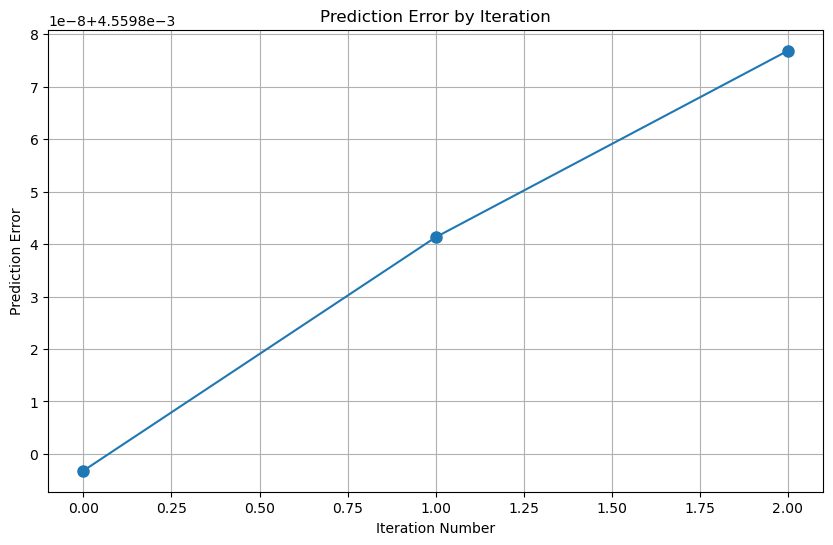

In [13]:
# Retrieve the prediction errors for each iteration
prediction_errors = model.pe_each_iter

# Plotting the prediction errors
plt.figure(figsize=(10, 6))
plt.plot(prediction_errors, marker="o", linestyle="-", markersize=8)
plt.title("Prediction Error by Iteration")
plt.xlabel("Iteration Number")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.show()

> I choose my stopping point at iteration number 1.

In [14]:
model_new = dame_flame.matching.DAME(
    repeats=False,
    verbose=3,
    want_pe=True,
    stop_unmatched_t=True,
    early_stop_iterations=0,  # Stop after iteration 1
)
model_new.fit(
    insurance,
    treatment_column_name="HINOTCOVE",
    outcome_column_name="CNLUNG",
)
result_new = model_new.predict(insurance)

Completed iteration 0 of matching
	Number of matched groups formed in total:  991
	Unmatched treated units:  3378 out of a total of  185892 treated units
	Unmatched control units:  33 out of a total of  32088 control units
	Number of matches made this iteration:  214569
	Number of matches made so far:  214569
	Covariates dropped so far:  set()
	Predictive error of covariate set used to match:  0.004559796810897787
214569 units matched. We stopped after iteration 0


In [15]:
def get_dataframe(model, result_of_fit):

    # Get original data
    better = model.input_data.loc[result_of_fit.index]
    if not better.index.is_unique:
        raise ValueError("Need index values in input data to be unique")

    # Get match groups for clustering
    better["match_group"] = np.nan
    better["match_group_size"] = np.nan
    for idx, group in enumerate(model.units_per_group):
        better.loc[group, "match_group"] = idx
        better.loc[group, "match_group_size"] = len(group)

    # Get weights. I THINK this is right?! At least for with repeat=False?
    t = model.treatment_column_name
    better["t_in_group"] = better.groupby("match_group")[t].transform(np.sum)

    # Make weights
    better["weights"] = np.nan
    better.loc[better[t] == 1, "weights"] = 1  # treaments are 1

    # Controls start as proportional to num of treatments
    # each observation is matched to.
    better.loc[better[t] == 0, "weights"] = better["t_in_group"] / (
        better["match_group_size"] - better["t_in_group"]
    )

    # Then re-normalize for num unique control observations.
    control_weights = better[better[t] == 0]["weights"].sum()

    num_control_obs = len(better[better[t] == 0].index.drop_duplicates())
    renormalization = num_control_obs / control_weights
    better.loc[better[t] == 0, "weights"] = (
        better.loc[better[t] == 0, "weights"] * renormalization
    )
    assert better.weights.notnull().all()

    better = better.drop(["t_in_group"], axis="columns")

    # Make sure right length and values!
    # assert len(result_of_fit) == len(better)
    # assert better.loc[better[t] == 0, "weights"].sum() == num_control_obs

    return better

In [16]:
matched_data = get_dataframe(model_new, result_new)
matched_data.head()

,SEX,RACENEW,INCFAM97ON2,HINOTCOVE,CNLUNG,SMK,Occupation_Code,match_group,match_group_size,weights
191658,2,100,32,1,0,1,1,262.0,1070.0,1.000000
191659,1,100,20,0,0,2,10,128.0,447.0,0.275558
191660,1,100,20,1,0,1,9,122.0,1861.0,1.000000
191661,2,100,10,1,0,2,10,39.0,1959.0,1.000000
191662,1,100,32,1,0,1,1,261.0,296.0,1.000000


In [17]:
matched_data.shape

(214569, 10)

In [18]:
cnlung_counts = matched_data["CNLUNG"].value_counts()

print("Count of each unique value in CNLUNG:")
print(cnlung_counts)

Count of each unique value in CNLUNG:
CNLUNG
0    213842
1       727
Name: count, dtype: int64


In [19]:
print(f"Checking the Columns in matched data:")
matched_data.columns

Checking the Columns in matched data:


Index(['SEX', 'RACENEW', 'INCFAM97ON2', 'HINOTCOVE', 'CNLUNG', 'SMK',
       'Occupation_Code', 'match_group', 'match_group_size', 'weights'],
      dtype='object')

In [20]:
# Model with controls and robustness check
model_with_controls = smf.wls(
    "CNLUNG ~ C(HINOTCOVE) + C(SEX) + C(RACENEW) + C(INCFAM97ON2) + C(SMK) + C(Occupation_Code)",
    data=matched_data,
    weights=matched_data["weights"],
).fit(cov_type="HC3")

In [21]:
model_with_controls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                 CNLUNG   R-squared:                       0.004
Model:                            WLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     16.30
Date:                Wed, 01 May 2024   Prob (F-statistic):           5.57e-87
Time:                        06:57:03   Log-Likelihood:             3.0038e+05
No. Observations:              214569   AIC:                        -6.007e+05
Df Residuals:                  214537   BIC:                        -6.004e+05
Df Model:                          31                                         
Covariance Type:                  HC3                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0051      0.001      9.943      0.000       0.004       0.006
C(HINOTCOVE)[T.1]            0.0032      0.000     15.199      0.000       0.003       0.004
C(SEX)[T.2]                  0.0007      0.000      2.332      0.020       0.000       0.001
C(RACENEW)[T.200]           -0.0004      0.000     -0.995      0.320      -0.001       0.000
C(RACENEW)[T.300]           -0.0024      0.001     -2.196      0.028      -0.005      -0.000
C(RACENEW)[T.400]           -0.0009      0.000     -2.468      0.014      -0.002      -0.000
C(INCFAM97ON2)[T.20]        -0.0016      0.000     -4.664      0.000      -0.002      -0.001
C(INCFAM97ON2)[T.31]        -0.0023      0.000     -5.268      0.000      -0.003      -0.001
C(INCFAM97ON2)[T.32]        -0.0032      0.000     -9.571      0.000      -0.004      -0.003
C(SMK)[T.2]                 -0.0058      0.000    -19.656      0.000      -0.006      -0.005
C(Occupation_Code)[T.2]      0.0010      0.001      1.789      0.074   -9.31e-05       0.002
C(Occupation_Code)[T.3]     -0.0003      0.001     -0.578      0.563      -0.001       0.001
C(Occupation_Code)[T.4]      0.0021      0.001      2.905      0.004       0.001       0.003
C(Occupation_Code)[T.5]     -0.0001      0.000     -0.212      0.832      -0.001       0.001
C(Occupation_Code)[T.6]      0.0003      0.001      0.466      0.641      -0.001       0.002
C(Occupation_Code)[T.7]      0.0006      0.001      1.009      0.313      -0.001       0.002
C(Occupation_Code)[T.8]      0.0006      0.001      0.979      0.328      -0.001       0.002
C(Occupation_Code)[T.9]      0.0003      0.001      0.316      0.752      -0.001       0.002
C(Occupation_Code)[T.10]    -0.0013      0.001     -2.085      0.037      -0.003   -7.87e-05
C(Occupation_Code)[T.11]    -0.0002      0.001     -0.282      0.778      -0.002       0.001
C(Occupation_Code)[T.12]     0.0016      0.001      1.612      0.107      -0.000       0.003
C(Occupation_Code)[T.13]    -0.0014      0.001     -2.289      0.022      -0.003      -0.000
C(Occupation_Code)[T.14]    -0.0012      0.001     -1.553      0.120      -0.003       0.000
C(Occupation_Code)[T.15]     0.0010      0.001      1.132      0.258      -0.001       0.003
C(Occupation_Code)[T.16]    -0.0004      0.001     -0.532      0.595      -0.002       0.001
C(Occupation_Code)[T.17]    -0.0005      0.001     -0.567      0.571      -0.002       0.001
C(Occupation_Code)[T.18]    -0.0009      0.001     -1.334      0.182      -0.002       0.000
C(Occupation_Code)[T.21] -7.396e-05      0.001     -0.117      0.907      -0.001       0.001
C(Occupation_Code)[T.23]    -0.0006      0.001     -0.705      0.481      -0.002       0.001
C(Occupation_Code)[T.24]     0.0110      0.005      2.337      0.019       0.002       0.020
C(Occupation_C

In [22]:
# To get the coefficient for the 'HINOTCOVE' variable
insurance_coefficient_control = model_with_controls.params["HINOTCOVE"]
print(f"Coefficient for 'HINOTCOVE' with controls: {insurance_coefficient_control:.4f}")

KeyError: 'HINOTCOVE'

In [ ]:
# To get the p-value for the coefficient of 'HINOTCOVE' variable
insurance_p_value_control = model_with_controls.pvalues["HINOTCOVE"]
print(f"P-value for 'HINOTCOVE' with controls: {insurance_p_value_control:.4f}")

>- The coefficient for 'HINOTCOVE' with controls (0.0010) suggests that, after controlling for other variables, there is a positive association between having insurance coverage and the outcome variable (lung cancer diagnosis status). 
>- The p-value is less than the conventional threshold of 0.05, suggesting that the estimated effect of insurance coverage on lung cancer diagnosis is statistically significant.
>- There is evidence to support the hypothesis that having insurance coverage increases the likelihood of lung cancer diagnosis, after controlling for other covariates and potential confounders.